<h1 align=center><b>2023 Principle of Data Analytics</b></h1>
<h1 align=center>Analysis of the Palmer Penguins Dataset</h1>
<h3 align=center>Guillermo F. Martin Gonzalez</h3>

**Table of contents**<a id='toc0_'></a>    
- [1. Introduction](#toc1_)    
  - [1.1 Hypothesis](#toc1_1_)    
- [2. Statistical analysis](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Python packages used in the current notebook
import pandas as pd #import pandas library and name it pd
import numpy as np #import numpy library and name it np
import seaborn as sns #import seaborn library and name it sns

# <a id='toc1_'></a>[1. Introduction](#toc0_)

This jupyter notebook contains the analysis presented for the 2024 course Principle of Data Analytics as part of the Higher Diploma in Science in Data Analytics provided by the Atlantic Technological University. The details of the assessment are provided here: https://ianmcloughlin.github.io/2324_principles_of_data_analytics/


The dataset contains a total of 7 columns. We can divide the columns in two main categories: 

* <u>Response variables</u>: four different variable related to biological traits, namely bill length (mm), bill depth (mm), flipper length (mm) and body mass (gr). 
* <u>Covariates</u>: three columns which contain information about the sample itself such as the penguin specie, presumably the island where the data was taken, the sex of the individual. 

In [2]:
# Load the penguins dataset and have a first look at it
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") # Load the data. Replace by the https of the raw penguins file. 
#df.head() # Look at the heading of the data
#df.drop('Unnamed: 0', inplace=True, axis=1) # Remove the "Unnamed" column
df.info() # Information about each column
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Now, a good way of understanding the type of data we have in front and the type of correlation that are present is to do a correlation plot or pair plot. From the pair plot shown below, there is a very clear positive correlation (increse in X with increase in Y) across all the biological traits described previously. These are the scatterplots. For visualization, we have also told the pair plot, to display the species name as the colour of the points. We can clearly see the "clusters" of the biological traits for each different specie (e.g flipper length and body mass are substantially larger in the Gentoo penguins; density plots further to the right). 

This is not unexpected, as different species would usually display differences in biological traits.  Now, as we are interested in understanding the potential correlation around biological traits, and given that these traits are quite different across the species in the data, further analysis should really consider the species column as a covariate. Another covariate worth looking at might be the island where the data was taken from or the sex of each individual, as usually, within an specie, biologial traits display different characteristics (sexual dimorphism).  


## <a id='toc1_1_'></a>[1.1 Hypothesis](#toc0_)

c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


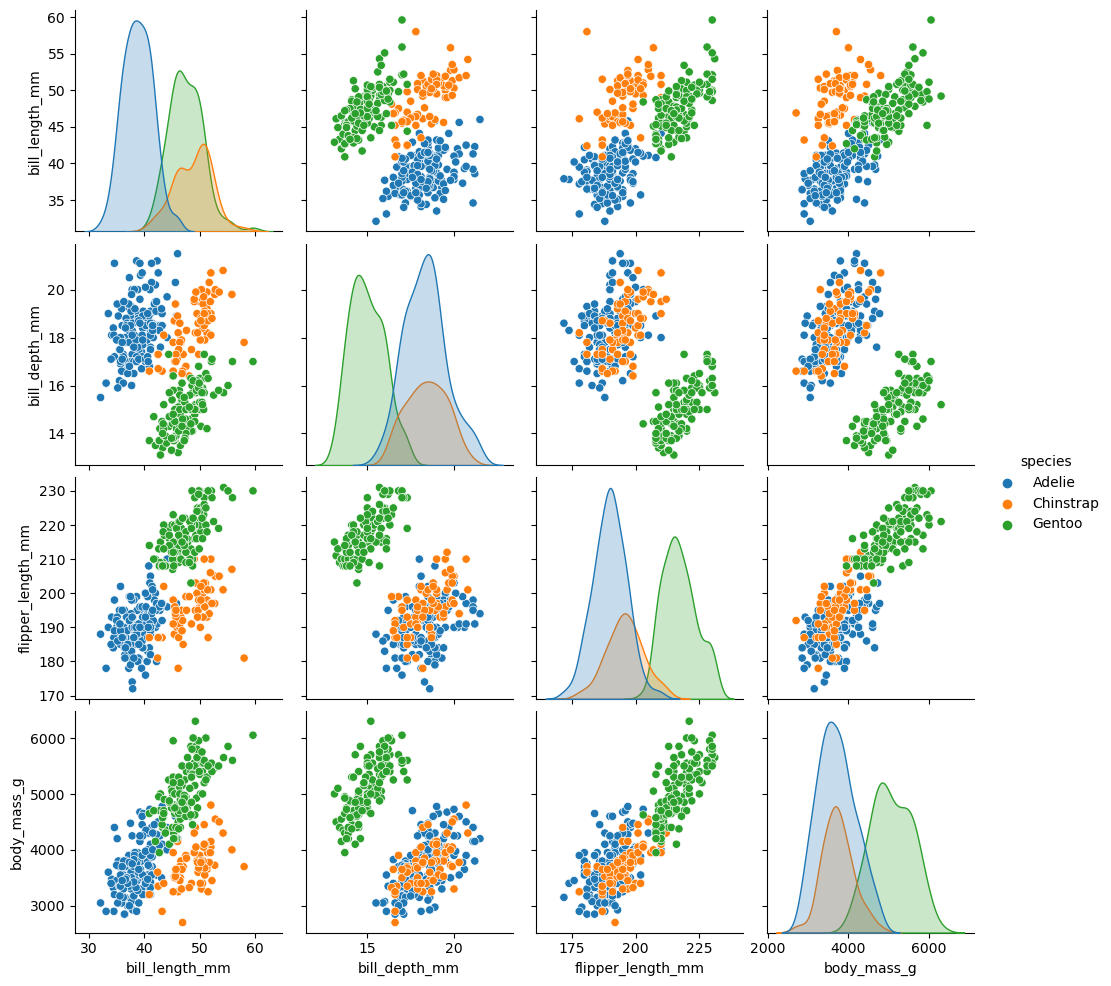

In [9]:
axes = sns.pairplot(df, hue="species")

c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\ggonzales\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


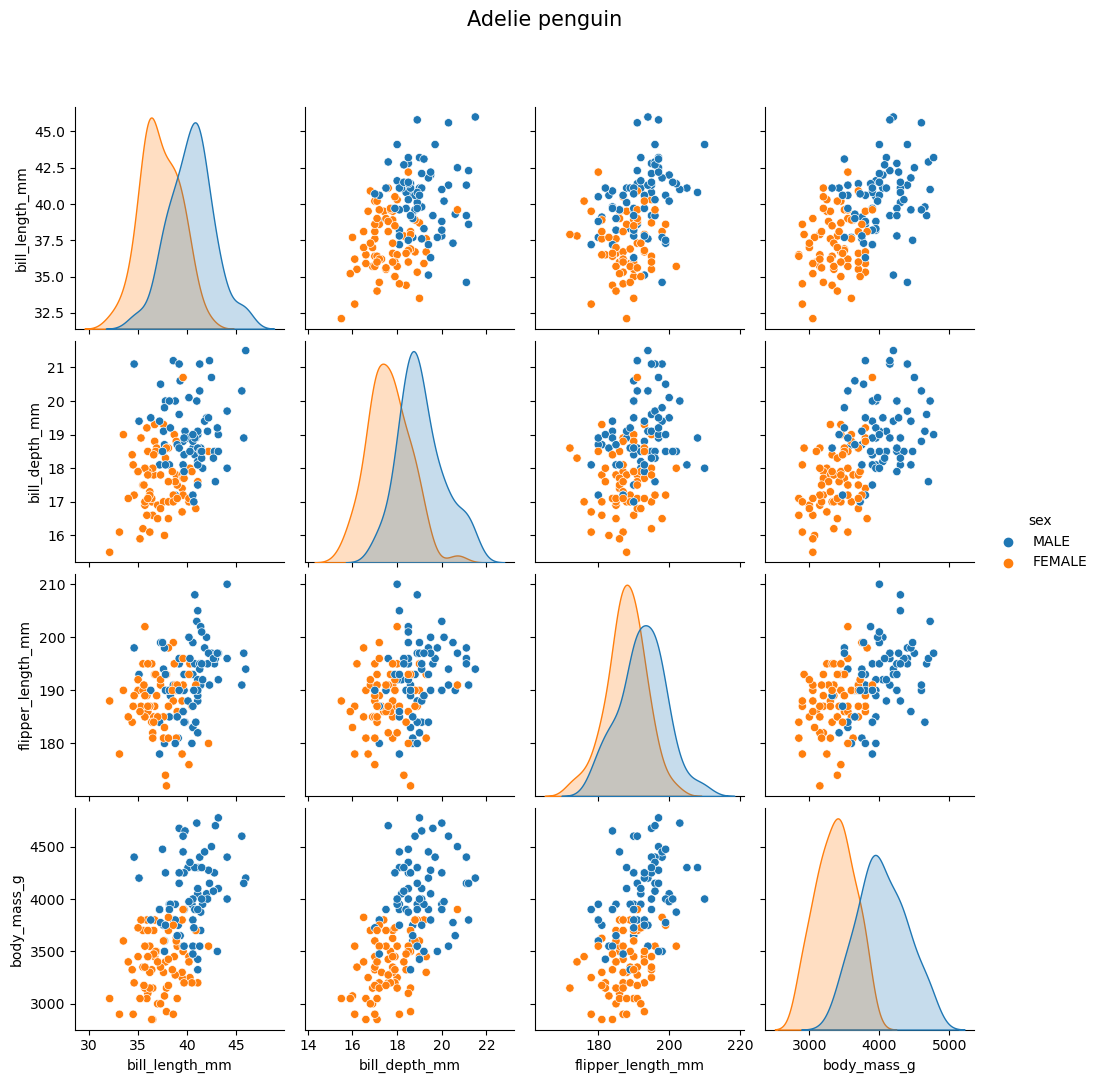

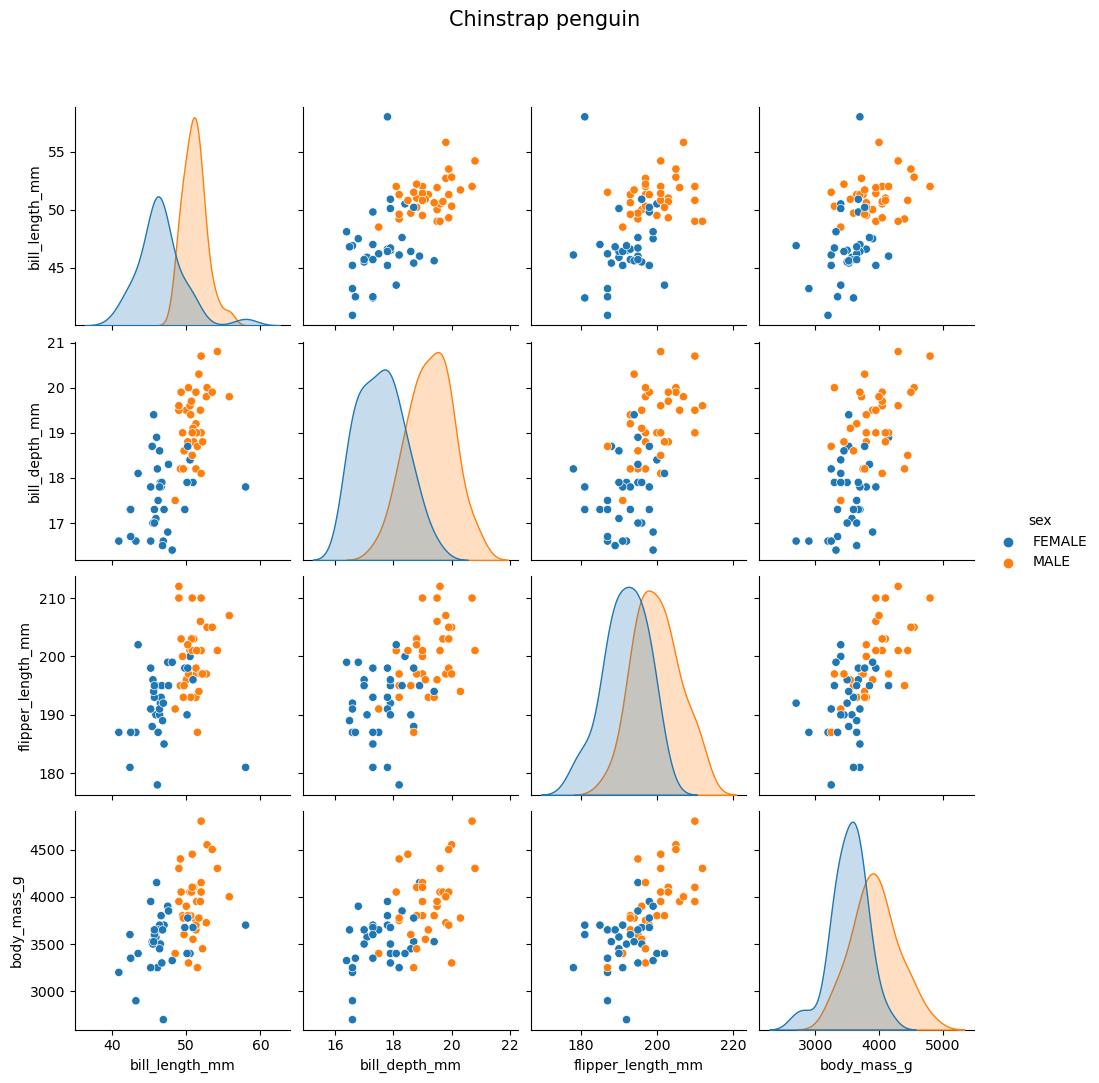

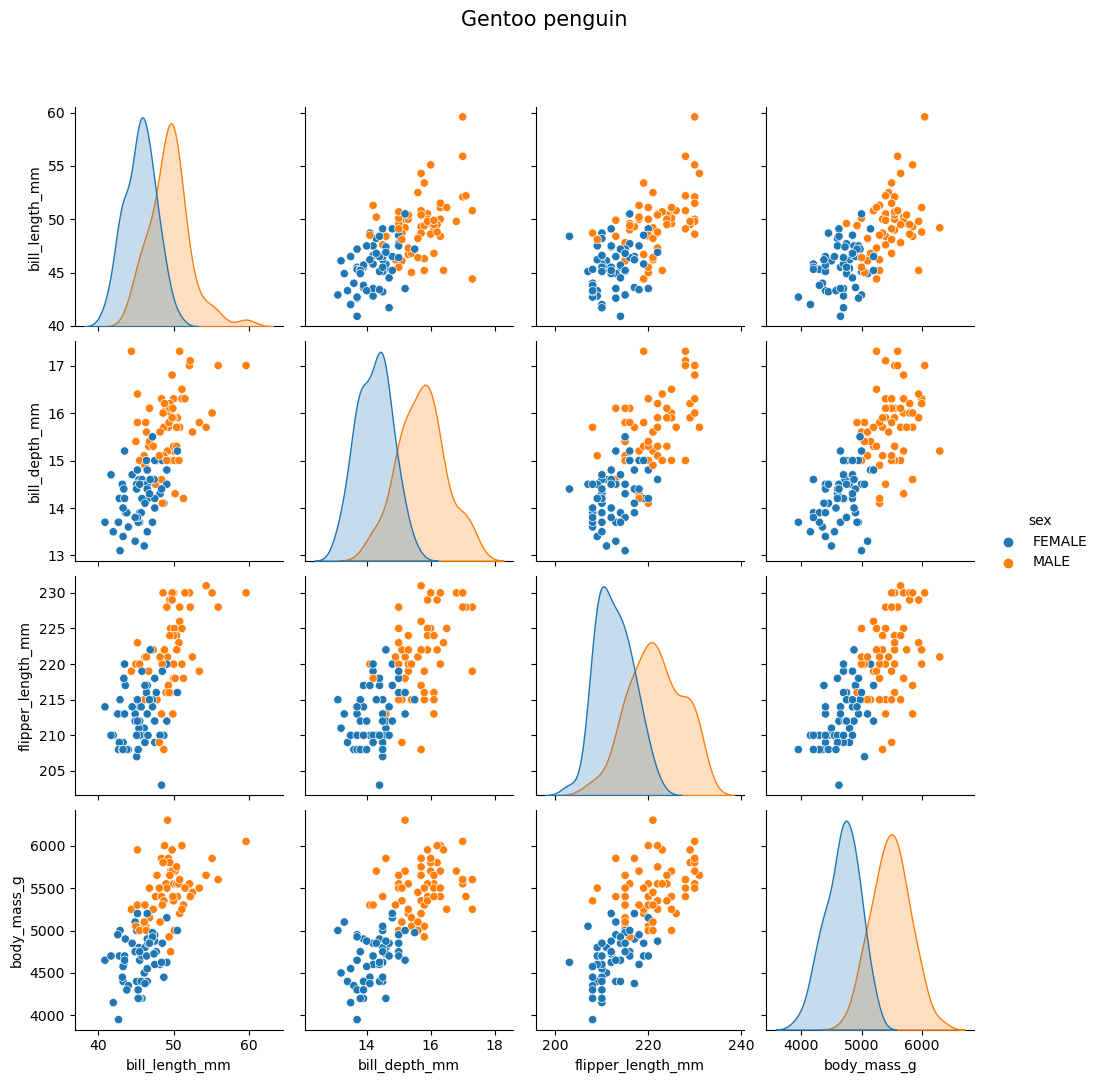

In [10]:
# Making a scatter plot for each specie using the sex as the coloured variable. 
for sp in df.species.unique(): # "for" loop. We will make a plot for each unique value of the species column
    # Create pairplot for the current species group
    p=sns.pairplot(df[df.species == sp], hue="sex") # Making plot for species sp, and colour te variables based on the sex column
    p.fig.suptitle(f"{sp} penguin", y=1.08, fontsize=15) # Create a title for each plot.

# <a id='toc2_'></a>[2. Statistical analysis](#toc0_)

hgewdcfgyhj545fwecd